<a href="https://colab.research.google.com/github/gulce0/IE-423/blob/main/Task_3_G%C3%BClce_Y%C4%B1ld%C4%B1z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Data




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dfCust = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/blackfriday/train.csv')

# Check for missing values in the target variable
print(dfCust['Purchase'].isnull().sum())


# Select target as a series and features as dataframe
y = dfCust.loc[:,['Purchase']].values.ravel()
X = dfCust.drop(['Purchase'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

0


### Visualizing Data

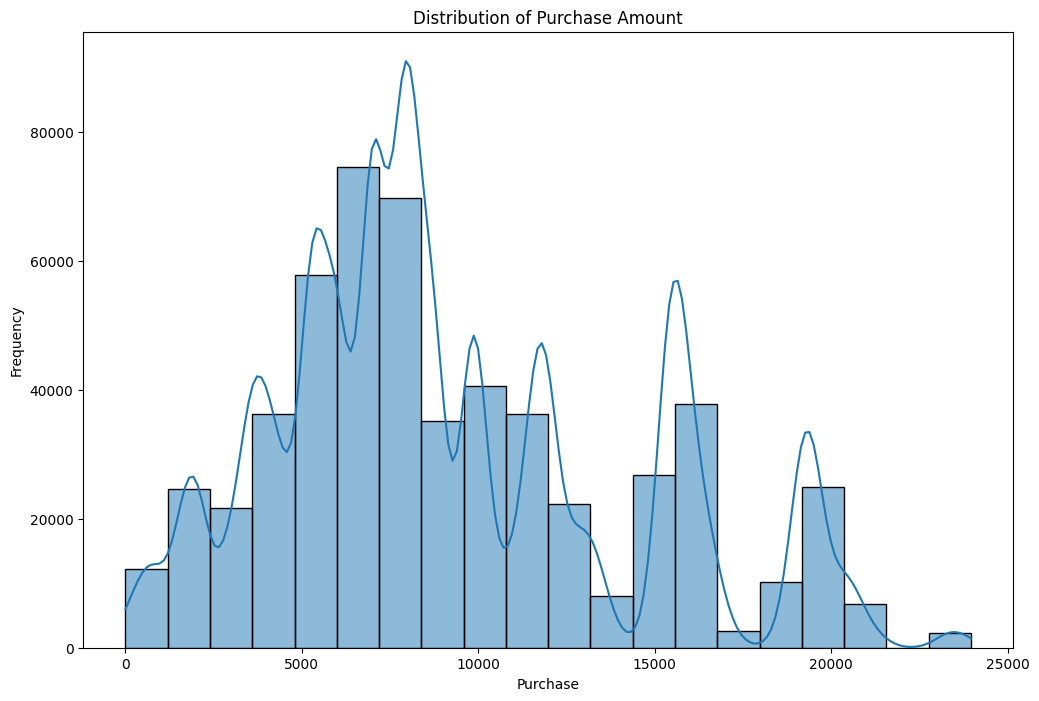

In [16]:
plt.figure(figsize=(12, 8))
sns.histplot(dfCust['Purchase'], bins=20, kde=5)
plt.title('Distribution of Purchase Amount')
plt.xlabel('Purchase')
plt.ylabel('Frequency')
plt.show()


<Axes: xlabel='Gender', ylabel='Count'>

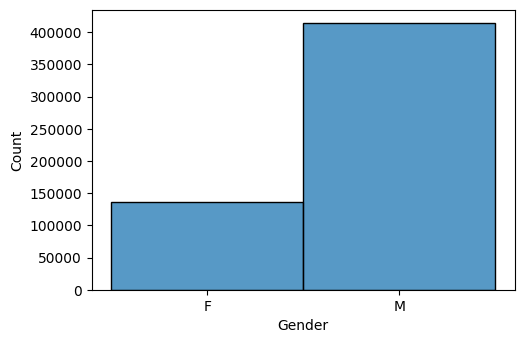

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.histplot(dfCust["Gender"])

### Building Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Function for building and scoring Random Forest models
def get_random_forest_mae(X_trn, X_tst, y_trn, y_tst):
    mdlRfsCust = RandomForestRegressor(random_state=1)
    mdlRfsCust.fit(X_trn, y_trn)
    y_tst_prd = mdlRfsCust.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return (mae)

We cannot build a model with all feature since some of the columns are non-numeric Specifically, the "Gender" column is non-numeric because it contains categorical data (e.g., "Male" and "Female"). I need to encode these categorical columns into numeric format. Additionally i need to handle ***numerical and non-numerical features*** in different cases.

### ***1. Numerical Features***

In [ ]:
# Select numeric features
cols_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
Xnum = X[cols_num]

# Split numeric features into training and test sets
Xnum_train, Xnum_test, y_train, y_test = train_test_split(Xnum,y,train_size=0.8, test_size=0.2,random_state=1)

In [94]:
Xnum.head()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,10,0,3,NaN,NaN
1,1000001,10,0,1,6.0,14.0
2,1000001,10,0,12,NaN,NaN
3,1000001,10,0,12,14.0,NaN
4,1000002,16,0,8,NaN,NaN


In [ ]:
Xnum.describe(include = 'all')

In [ ]:
Xnum.info()

In [ ]:
# Count number of missing values in each column of the training data
Xnum_train.isna().sum()

User_ID                    0
Occupation                 0
Marital_Status             0
Product_Category_1         0
Product_Category_2    138892
Product_Category_3    306504
dtype: int64

We see that some of the numeric columns have **missing values**. There are 2 ways to handle this issue.

#### *Approach A:  Drop Columns with Missing Values*

In [ ]:
# Identify columns with missing values and then drop such columns
cols_num_null = [col for col in Xnum_train.columns
    if Xnum_train[col].isnull().any()]
Xnum_train_drpnull = Xnum_train.drop(cols_num_null, axis=1)
Xnum_test_drpnull = Xnum_test.drop(cols_num_null, axis=1)

In [ ]:
print('MAE from Approach A (Drop features with missing values):')
print(get_random_forest_mae(Xnum_train_drpnull, Xnum_test_drpnull, y_train, y_test))

MAE from Approach A (Drop features with missing values):
2091.2402741391948


After dropping missing values in numeric features, the MAE obtained is  $2091.

#### *Approach B: Filling Missing Values by Imputation*

Imputation means missing values with some number such as mean value or back, forward values along each column.

In [ ]:
# Replace with specific value (0, bfill, ffill)
Xnum_train_repnull = Xnum_train.fillna(method = 'ffill')
Xnum_test_repnull = Xnum_test.fillna(method = 'ffill')

# If 'ffill' couldn't fill all NaNs, use 'bfill' to fill NaNs from the back
Xnum_train_repnull = Xnum_train_repnull.fillna(method='bfill')
Xnum_test_repnull = Xnum_test_repnull.fillna(method='bfill')

# Check if there are still any missing values after filling
print("Missing values in Xnum_train_repnull:", Xnum_train_repnull.isnull().sum().sum())
print("Missing values in Xnum_test_repnull:", Xnum_test_repnull.isnull().sum().sum())

print('MAE from Approach B :(Replace missing values with forward fill, if ffill does not work bfill technique is used):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

Missing values in Xnum_train_repnull: 0
Missing values in Xnum_test_repnull: 0
MAE from Approach 2 (Replace missing values with forward fill, if ffill does not work bfill technique is used):
2272.049645096092


After filling missing values with back-forward values, the MAE obtained is: $2272

In [ ]:
# Replace with mean value
Xnum_train_repnull = Xnum_train.fillna(Xnum_train.mean())
Xnum_test_repnull = Xnum_test.fillna(Xnum_train.mean())

print('MAE from Approach B (Replace missing values with mean):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach B (Replace missing values with mean):
2193.456214200903


In [ ]:
# Going forward, let us replace all missing numeric values with the column mean
X_train[cols_num]=Xnum_train_repnull[cols_num]
X_test[cols_num]=Xnum_test_repnull[cols_num]

# Handle categorical features (example: encoding)
X['Gender'] = X['Gender'].map({'M': 1, 'F': 0})
X = pd.get_dummies(X, columns=['Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status'])

After filling missing values with mean value, the MAE obtained is: $2193

Dropping columns with missing values gives better MAE results than filling missing values with imputation. It probably means that columns with missing values do not contribute much to the prediction or are noisy, removing them can actually improve the model's performance.

###  ***2. Non-Numerical Features***

We have handled numerival features so far. Now we need to work with non-numerical features. Converting them to numeric features is necessary.

In [ ]:
# Select non-numeric features
cols_obj = [col for col in X.columns if X[col].dtype == 'object']
cols_obj

['Product_ID']

Since there are many values to be label encoded and it is not possible to handle all of them, we need to take only categorical features to label.

In [ ]:
# Select categorical features
cols_cat = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<10]
cols_cat

[]

In [ ]:
# Label encoding on only categorical features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

print("Number of NaNs in Xle_train:", Xle_train.isna().sum().sum())
print("Number of NaNs in Xle_test:", Xle_test.isna().sum().sum())

Number of NaNs in Xle_train: 0
Number of NaNs in Xle_test: 0


In [84]:
# Encode and Build/Score using all Categorical columns

mae = get_random_forest_mae(Xle_train[cols_num + cols_cat], Xle_test[cols_num + cols_cat], y_train, y_test)
print("MAE from Label Encoding all Categorical columns:")
print(mae)

MAE from Label Encoding all Categorical columns:
2193.456214200903


So, by including the Categorical features, the MAE is further reduced to to $2154 which is the best result so far.

### Building Gradient Boosted Tree Model

While the Random Forest model is - as the name suggests - "Random", what if consequent decision trees are added to the ensemble in such a way that the loss function (Mean Squared Error) is minimized?  This is what a gradient descent function helps with in the **Gradient Boosting** model. GBMs are a type of ensemble learning method, where multiple models (in this case, decision trees) are combined to produce a stronger model.


In [ ]:
from xgboost import XGBRegressor

#Build and score default Gradient Boosting Model
mdlXgbCust = XGBRegressor()
mdlXgbCust.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbCust.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

MAE from default XGBoost model:
2090.9818629360047


This result is the best one so far. Selecting trees to add to the ensemble using gradient descent combined with proper parameter tuning helps to significantly improve the result.

In [ ]:
#Build and score a tuned Gradient Boosting Model
mdlXgbCust = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=5)
mdlXgbCust.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbCust.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from tuned XGBoost model:")
print(mae)

MAE from tuned XGBoost model:
2100.3951026451473


In [93]:
learning_rates = [0.010, 0.10, 0.15, 0.2]
results = {}

for lr in learning_rates:
    mdlXgbCust = XGBRegressor(n_estimators=5000, learning_rate=lr, max_depth=5)
    mdlXgbCust.fit(Xle_train[cols_num + cols_cat], y_train)
    y_test_pred = mdlXgbCust.predict(Xle_test[cols_num + cols_cat])
    mae = mean_absolute_error(y_test_pred, y_test)
    results[lr] = mae
    print(f"MAE from XGBoost model with learning rate={lr}: {mae}")

MAE from XGBoost model with learning rate=0.01: 2131.6561527874064
MAE from XGBoost model with learning rate=0.1: 2074.5299500587153
MAE from XGBoost model with learning rate=0.15: 2074.9357661700788
MAE from XGBoost model with learning rate=0.2: 2077.673734991848


When the learning rate is increased from 0.01 to 0.1, there is a discernible improvement in MAE, suggesting that a higher learning rate is more effective for the model. With a minor increase in MAE from 0.15 to 0.2, further raising the learning rate to 0.15 and 0.2 exhibits diminishing returns.
With the lowest MAE (2074.530) among the assessed learning rates, 0.1 seems to be the best choice.

### Takeaways

MAE from Approach A (Drop features with missing values):
2091.2402741391948

MAE from Approach B (Replace missing values with mean):
2193.456214200903

MAE from Approach of Replacing missing values with forward fill, if ffill does not work bfill technique is used:
2272.049645096092

MAE from Label Encoding all Categorical columns:
2193.456214200903

MAE from default XGBoost model:
2090.9818629360047

MAE from XGBoost model with learning rate=0.01: 2131.6561527874064

MAE from XGBoost model with learning rate=0.1: 2074.5299500587153

MAE from XGBoost model with learning rate=0.15: 2074.9357661700788

MAE from XGBoost model with learning rate=0.2: 2077.673734991848